In [3]:
import pandas as pd
df = pd.read_csv(str('F:\Adult.gem'), sep='\t', comment='#', header=0)

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix
from scipy.stats import wasserstein_distance


def cos_similarity_distance(x, y):
    '''Culculate the cosin similarity distance between two vectors'''
    if x.shape != y.shape:
        raise ValueError('x and y must have same dimensions.')
    x = np.array(x)
    y = np.array(y)
    return 1 - np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))


def sub_index(center_index, distance, edge_index=0):
    return center_index - distance if center_index - distance > edge_index else edge_index


def add_index(center_index, distance, edge_index):
    return center_index + distance + 1 if center_index + distance <= edge_index else edge_index


def get_surround_matrix(matrix, index, distance):
    '''Get the surrounding matrix by index'''
    if distance < 1:
        raise ValueError("The value of distance must be larger than 0")
    row_edge = matrix.shape[0]
    col_edge = matrix.shape[1]
    row_index = index[0]
    col_index = index[1]
    return matrix[sub_index(row_index, distance): add_index(row_index, distance, row_edge),
                  sub_index(col_index, distance): add_index(col_index, distance, col_edge)]


def merge_bin_coor(coor: np.ndarray, coor_min: int, bin_size: int):
    return np.floor((coor - coor_min) / bin_size).astype(np.int)


def get_bin_center(bin_coor: np.ndarray, coor_min: int, bin_size: int):
    return bin_coor * bin_size + coor_min + int(bin_size / 2)


def get_coor_matrix(df):
    '''Transfer gene expression df to expression matrix'''
    count = df.loc[:, ['x', 'y', 'MIDCounts']].groupby(
        ['x', 'y'], as_index=False).sum('MIDCounts')
    merge_count = 20
    bins = [np.array(range(count['x'].min(), count['x'].max()+merge_count, merge_count)),
            np.array(range(count['y'].min(), count['y'].max()+merge_count, merge_count))]
    H, xedges, yedges = np.histogram2d(x=count['x'],
                                       y=count['y'],
                                       weights=count['MIDCounts'],
                                       bins=bins)
    return H


def find_track(df):
    H = get_coor_matrix(df)
    # Culculate by columns
    col_total = []
    for i in range(1, H.shape[1]-1):
        dis_1 = wasserstein_distance(H[:, i], H[:, i+1])
        dis_2 = wasserstein_distance(H[:, i], H[:, i-1])
        wd_average = (dis_1 + dis_2)/2
        col_total.append(wd_average)
    # Culculate by row
    row_total = []
    for i in range(1, H.shape[0]-1):
        dis_1 = wasserstein_distance(H[i, :], H[i+1, :])
        dis_2 = wasserstein_distance(H[i, :], H[i-1, :])
        wd_average = (dis_1 + dis_2)/2
        row_total.append(wd_average)
    return {'row': row_total, 'col': col_total}


def fill_track(track_matrix):
    '''
    track_matrix: A matrix containing track locations with value of 1
    '''
    shape = track_matrix.shape
    matrix = csr_matrix(np.zeros(shape))


def find_undersampled_pixel(H, distance, mean_percentage=0.2):
    '''
    distance: The Chebyshev distance of surround_matrix to pixel location
    mean_percentage: The percentage threshold to compare against the mean value of surround_matrix
    '''
    bad_matrix = np.zeros(H.shape)
    for index, value in np.ndenumerate(H):
        surround_matrix = get_surround_matrix(H, index, distance)
        is_lower_than_mean = surround_matrix.mean() * mean_percentage > value
        not_blank_region = np.median(surround_matrix) > 0
        is_square_matrix = surround_matrix.shape[0] == surround_matrix.shape[1]
        is_undersampled = is_lower_than_mean & is_square_matrix & not_blank_region & (
            value > 0)
        if is_undersampled:
            bad_matrix[index[0], index[1]] = 1
    return bad_matrix


def enhance_df_info(df):
    '''Enhance df information'''
    bin_size = 20
    x_min = df['x'].min()
    y_min = df['y'].min()
    df['bin_x'] = merge_bin_coor(df['x'].values, x_min, bin_size)
    df['bin_y'] = merge_bin_coor(df['y'].values, y_min, bin_size)
    df['x_center'] = get_bin_center(df['bin_x'], x_min, bin_size)
    df['y_center'] = get_bin_center(df['bin_y'], y_min, bin_size)
    df['cell_id'] = df['bin_x'].astype(str) + '_' + df['bin_y'].astype(str)
    return df


def get_bins_genes_matrix(df):
    '''Get [bins * genes] matrix from inhanced dataframe(enhance_df_info)'''
    cells = df['cell_id'].unique()
    genes = df['geneID'].unique()
    cells_dict = dict(zip(cells, range(0, len(cells))))
    genes_dict = dict(zip(genes, range(0, len(genes))))
    if 'MIDCounts' in df.columns:
        df.rename(columns={'MIDCounts': 'UMICount'}, inplace=True)
    elif 'MIDCount' in df.columns:
        df.rename(columns={'MIDCount': 'UMICount'}, inplace=True)
    rows = df['cell_id'].map(cells_dict)
    cols = df['geneID'].map(genes_dict)
    bins_genes_matrix = csr_matrix((df['UMICount'], (rows, cols)),
                                   shape=(cells.shape[0], genes.shape[0]),
                                   dtype=np.int32)
    return bins_genes_matrix


def view_matrix(matrix, dpi=200):
    plt.figure(dpi=dpi)
    sns.heatmap(matrix,
                cmap=sns.blend_palette(['white', 'black'], as_cmap=True))


<AxesSubplot:>

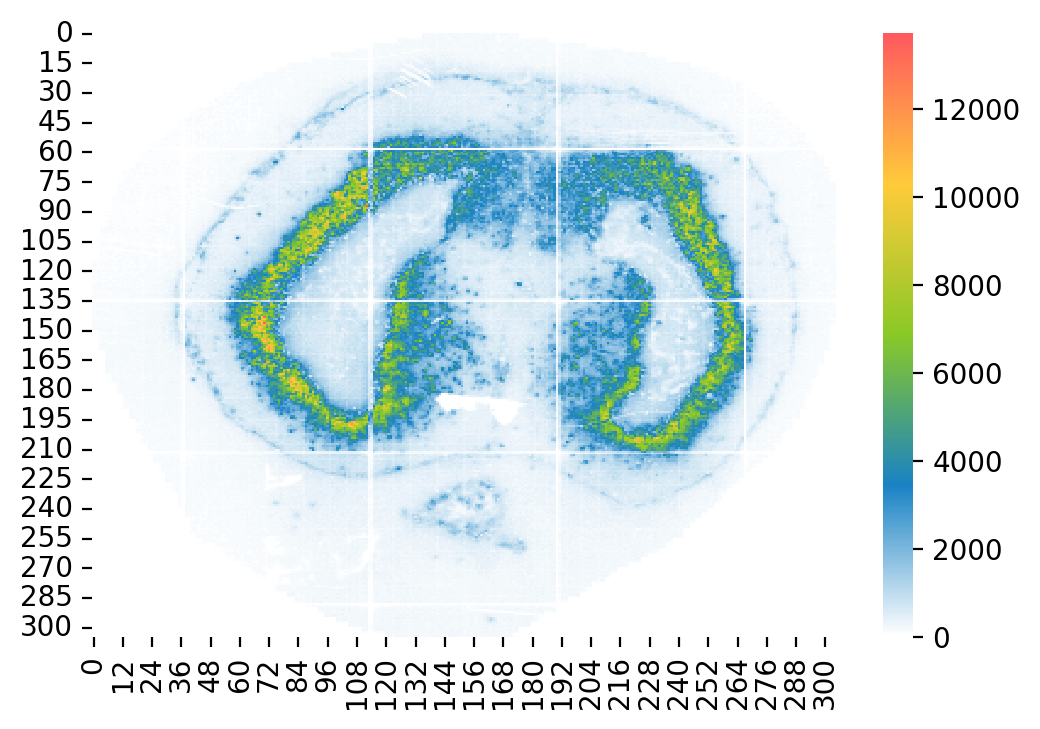

In [147]:
plt.figure(dpi=200)
sns.heatmap(H, cmap=sns.blend_palette(['white',
                                       '#1982C4',
                                       '#8AC926',
                                       '#FFCA3A',
                                       '#FF595E'], as_cmap=True))
